In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce # for merging dataframes
import re
import os

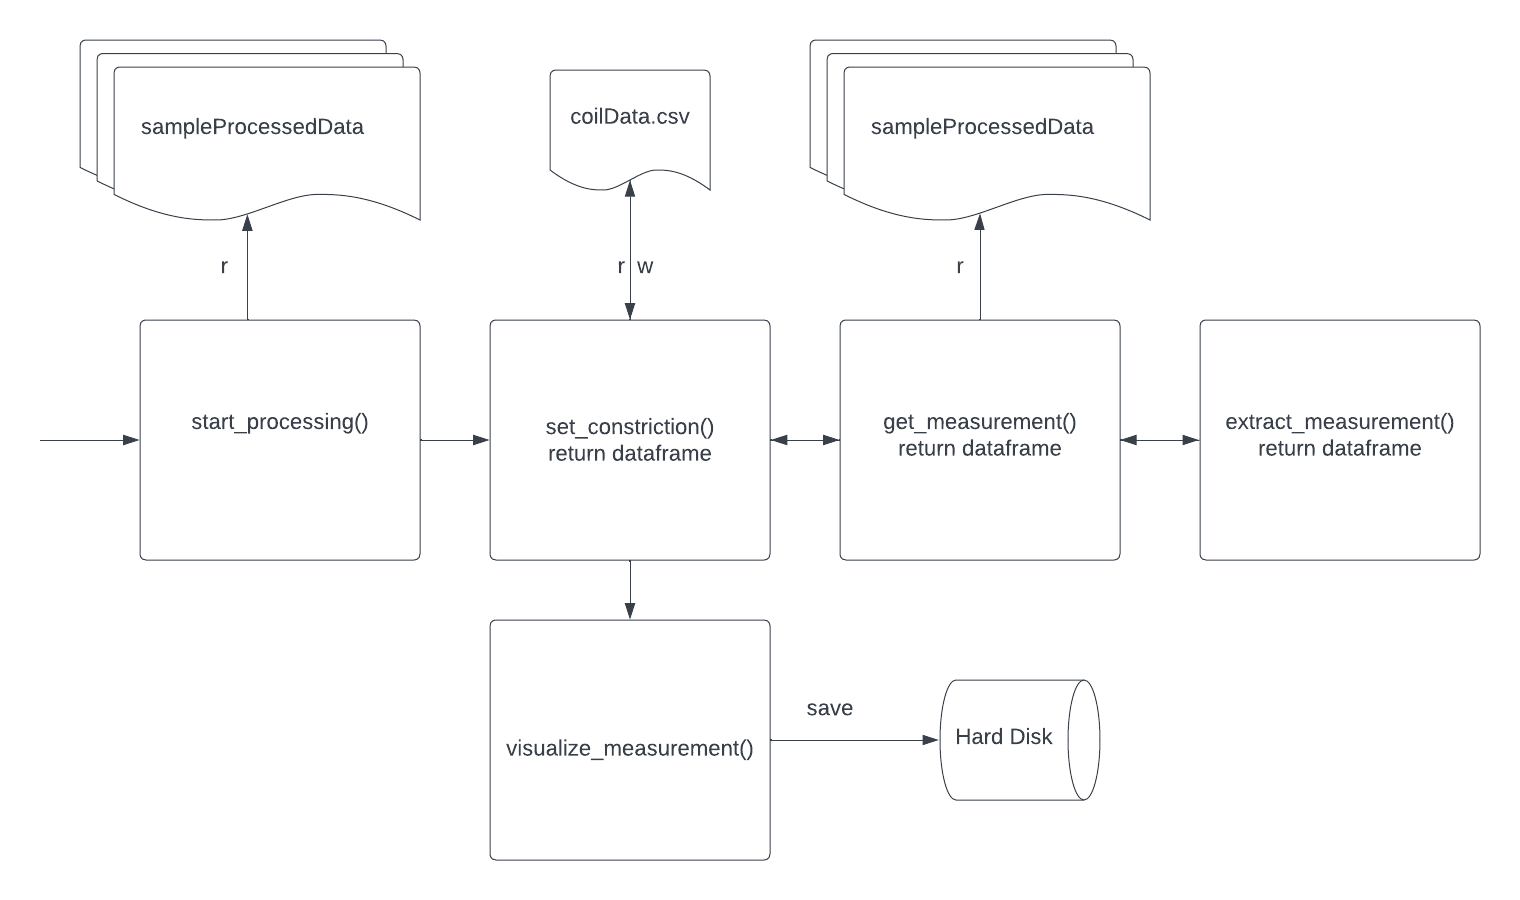

In [125]:
def extract_measurement(b_list, b_index):
    """
    This function extract the data points from B3,B4,B5 and 
    And return clean dataframe to get_measurment()
    """
    null_index = set() # a set to keep the index of null values in either x or y

    x_spos = b_list.index('LengthValue') # starting index of the x values
    y_spos = b_list.index('Value')# starting index of the y values
    y_epos = len(b_list)# the ending pos of y values
    
    x = b_list[x_spos + 1:y_spos]
    y = b_list[y_spos + 1: y_epos-1]

    # loop over x and get the index of the 'null' elements
    for index,value in enumerate(x):
        if value == "null":
            null_index.add(index)

    # loop over y and get the index of the 'null' elements
    for index,value in enumerate(y):
        if value == "null":
            null_index.add(index)    
    

    # removing the x,y pair with null value in either of them
    x = [value for idx, value in enumerate(x) if idx not in null_index]
    y = [value for idx, value in enumerate(y) if idx not in null_index]

    # changing the elements of x and y from string to float
    x_float =[float(item) for item in x]
    y_float =[float(item) for item in y]

    xy_dict = dict(zip(x_float,y_float)) # zip x and y  in dictionary
    xy_dict = {key: xy_dict[key] for key in xy_dict if key <= 500} # delete x,y pair for x > 500

    decode_dic = {0:'B3',1:'B4',2:'B5'}
    b_width = 'width_'+ decode_dic[b_index]
    
    b_df = pd.DataFrame(list(xy_dict.items()),columns = ['length',b_width])
    b_df['length'] = b_df['length'].astype(int) # convert float value to int
    grouped_b_df = b_df.groupby('length', as_index=False)[b_width].mean(numeric_only =True)
    
    return grouped_b_df



In [126]:
def get_measurement(coil_id):
    """
    This function load the data for B3,B4,B5 measurments
    It split the data based on ";"
    It calls extract_measuremnt() function to extract the 
    clean data pairs for B3,B4,B5
    nd return a data frame
    """

    root_directory = "data/SampleProcessedData/"
    all_B_df = [] # this list contain all b_df for B3,B4,B5(it is list of dataframes )

    b3_df = pd.read_csv(root_directory + str(coil_id ) + "B3.csv")
    b4_df = pd.read_csv(root_directory + str(coil_id ) + "B4.csv")
    b5_df = pd.read_csv(root_directory + str(coil_id ) + "B5.csv")

    b3_list = re.split(';', str(b3_df.columns))
    b4_list = re.split(';', str(b4_df.columns))
    b5_list = re.split(';', str(b5_df.columns))

    b_lists = [b3_list,b4_list,b5_list]
    for b_index, b_list in enumerate(b_lists):
        all_B_df.append(extract_measurement(b_list, b_index))
    
    # merge the dataframes for B3,B4,B5
    dfs = [all_B_df[0], all_B_df[1], all_B_df[2]] #define list of DataFrames
    final_B_df = reduce(lambda  left,right: pd.merge(left,right,on=['length'],
                                            how='outer'), dfs)# merge all DataFrames into one
    
    
    return final_B_df # return list of dataframes
    
    

In [127]:
def visualize_measurments(measurement_df, name, constriction, count):
    """
     This functions makes plot for each coil Id

    """

    constriction_dir ='images/constriction/'
    not_constriction_dir = 'images/not_constriction/'
    
    x_upper_limit = measurement_df['length'].max() - 10
    measurement_df=measurement_df[(measurement_df.length >=100) &(measurement_df.length <= x_upper_limit -10)]
    y_lower_limit, y_higher_limit = measurement_df[['width_B3', 'width_B4','width_B5']].min().min().min(), measurement_df[['width_B3', 'width_B4','width_B5']].max().max().max()
    
    fig, ax = plt.subplots()
    ax.plot(measurement_df['length'], measurement_df['width_B3'], color = 'b', label = 'B3', linewidth = 1)
    ax.plot(measurement_df['length'], measurement_df['width_B4'], color = 'r', label = 'B4', linewidth = 1)
    ax.plot(measurement_df['length'], measurement_df['width_B5'], color = 'g', label = 'B5', linewidth = 1)

    
    ax.set(xlabel='length in meters', ylabel='width in millimeters',title= name)

    ax.set_ylim(y_lower_limit -1, y_higher_limit + 1) # limit plot dynamically according the data
    ax.set_xlim(100,x_upper_limit)
    
    ax.set_xticks([120,190], minor=True)
    ax.xaxis.grid(True, which='minor')
    
    
    if constriction == 0: # saves images with constriction and not constriction in seperate folder
        fig.savefig(not_constriction_dir + str(name) +'.png', dpi = 72)
    else:
        fig.savefig(constriction_dir + str(name) + '.png', dpi = 72) 

    
    if count <= 5: # show plot only for the first 5 coils
        plt.show()
    else:
        plt.close()

    

In [128]:
def set_constriction():
    """ 
    This function determine whether a coil is constricted or not based on B3,B4,B5 measurement
    It adds a new column "Is_constriction" to the main data frame
    
    """
    main_df = pd.read_csv('data/CoilData.csv')
    coil_label_list = []   # keeps coil Id , Is_constriction(0|1),constriction_width
    invalid_coil_list = [] # keeps coil Id , with either B3,B4,B5  is missing  or has invalid data
    count = 0  # track the number of coils

    for value,name in main_df['coil'].items():
        
        try:
            measurement_df = get_measurement(name)
            targeted_measurement_df = measurement_df[(measurement_df.length >=120) &(measurement_df.length <= 190)].copy()
            targeted_measurement_df.loc[:, 'B3B4_mean_width'] = targeted_measurement_df.loc[:, ['width_B3','width_B4']].mean(1)
            targeted_measurement_df.loc[:, 'width_difference'] = targeted_measurement_df.loc[:, 'width_B5'] - targeted_measurement_df.loc[:, 'B3B4_mean_width']

            def constriction_status(value):
                if abs(value) <= 5:
                    return 0
                else:
                    return 1
            
            targeted_measurement_df.loc[:, 'Is_constriction'] = targeted_measurement_df.loc[:, 'width_difference'].map(constriction_status)
            constriction_width = len(targeted_measurement_df[targeted_measurement_df['Is_constriction']==1])

            if constriction_width >= 1:
                constriction = 1
            else:
                constriction = 0
            
            coil_label_list.append({'coil':name, 'Constriction_width':constriction_width, 'Is_constriction':constriction})
            count += 1 # increament number of coils processed
            visualize_measurments(measurement_df,name, constriction, count) # visualize
	             
        except:
            invalid_coil_list.append(name)
            
            continue
    
    label_df = pd.DataFrame(coil_label_list)
    main_labeled_df = pd.merge(main_df,label_df, on ='coil')
    print(f'{len(invalid_coil_list)} coils have either invalid data or missing either B3,B4 B5 file : ', invalid_coil_list)
    
    
    return main_labeled_df

In [129]:
def start_processing():

  """
  This function extract a coil Id which have B3,B4,B5 values from a folder directory, and save to a set.
  It gets mini dataframe from coil_df based on the extracted coil Id.
  And saves the mini dataframe into CoilData.csv file.
  And it calls set_constriction()

  """

  coil_list_const = set() # initiallize a set which will contain unique coil Id
  coil_df = pd.read_excel('data/CoilDataInput.xlsx')
 

  for file in os.listdir('data\SampleProcessedData'):
    if file.endswith("B3.csv"):#check the files which are end with specific extension
      a = file[:6]# print path name of selected files
      coil_list_const.add(a)
  coil_list_const_int =[int(item) for item in coil_list_const]# cast coil Id to int
  coil_merge_sample_df = coil_df[coil_df.coil.isin(coil_list_const_int)]
  #print(coil_merge_sample_df.head())
  coil_merge_sample_df.to_csv('data/CoilData.csv', index=False,header=True) # save df into csv file
  
  final_main_df = set_constriction()
  return final_main_df
  


  

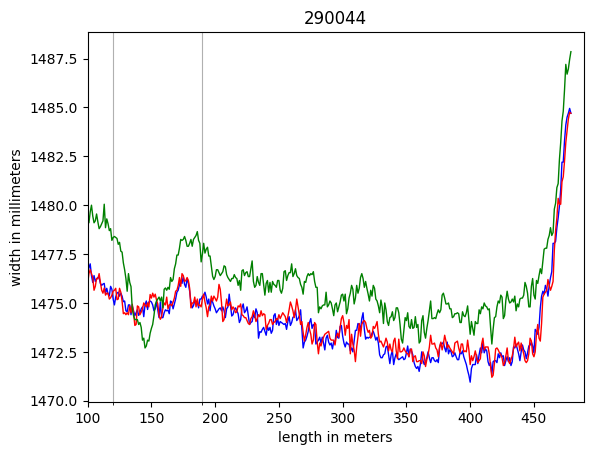

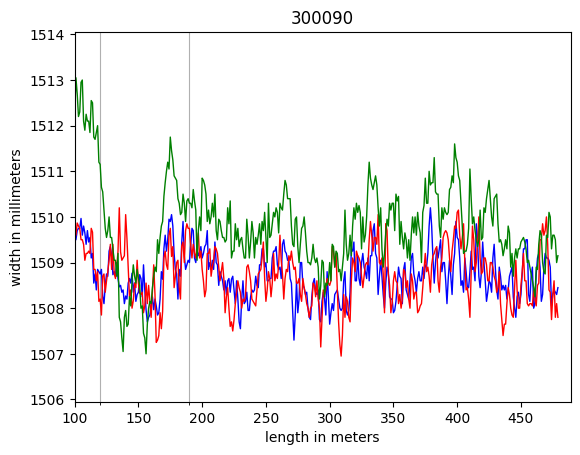

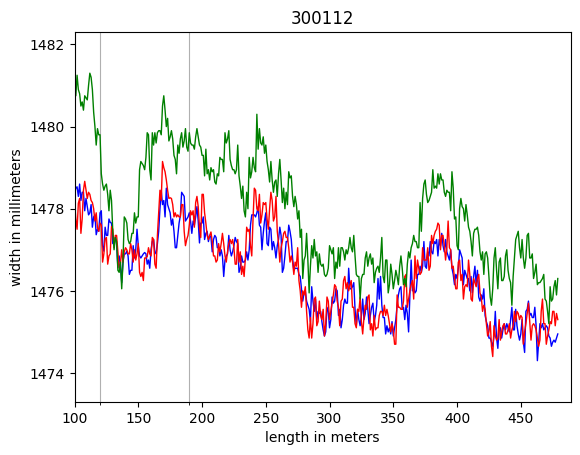

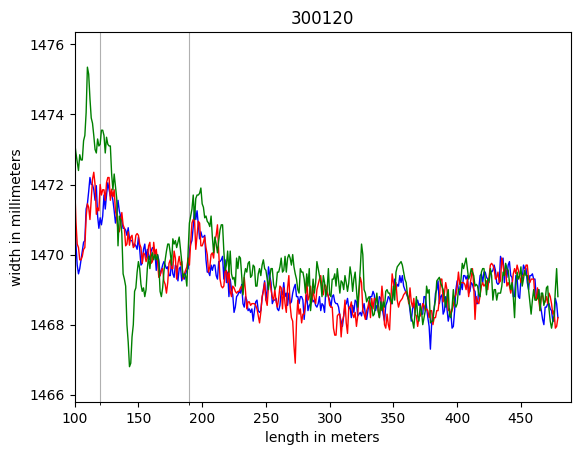

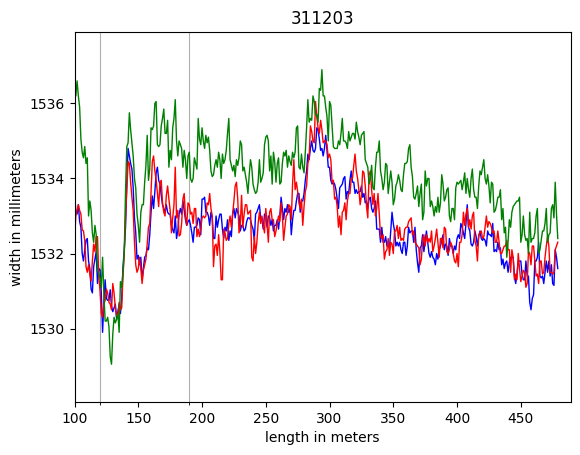

5 coils have either invalid data or missing either B3,B4 B5 file :  [311206, 311208, 311209, 311210, 311217]


,coil,furnace Number,analyse,Hardness_1,Hardness_2,Width,Temperature before finishing mill,Temperature after finishing mill,Thickness,Thickness profile,...,Al,M_Al,B,N,Ti,Cr,V,Mo,Constriction_width,Is_constriction
0,290044,1,T211,10488,92,1474.316667,1144.512093,925.00,3.66475,18.516072,...,515,493,1,20,615,146,0,15,0,0
1,300090,1,T231,10388,91,1508.583333,1149.062969,948.50,3.67625,27.850111,...,488,469,3,32,547,269,21,66,0,0
2,300112,1,T211,10422,91,1476.333333,1144.649197,943.50,3.74950,20.884563,...,440,419,1,29,541,158,20,11,0,0
3,300120,1,T211,10362,90,1468.716667,1169.235544,946.25,3.25625,31.832486,...,460,442,1,23,535,165,16,11,0,0
4,311203,1,K321,10195,102,1532.300000,1178.884199,914.50,2.20875,10.421023,...,325,308,0,18,7,88,0,5,0,0
5,311204,4,K371,10278,103,1531.466667,1152.865633,913.25,3.41400,6.095494,...,385,361,1,34,13,134,0,8,0,0
6,311205,1,K211,10070,101,1547.066667,1171.341134,916.75,5.51350,3.939607,...,309,296,1,26,12,189,11,12,71,1
7,311207,1,T211,10270,89,1513.350000,1140.735167,929.00,3.82275,29.393065,...,419,406,1,17,572,128,0,11,0,0
8,311211,1,T271,10596,93,1509.266667,1154.120226,944.00,3.71425,29.391171,...,638,617,3,20,587,148,20,13,0,0
9,311212,4,T218,10787,95,1508.950000,1146.115366,937.50,3.74325,30.241358,...,712,696,2,27,683,141,27,14,0,0


In [130]:
df = start_processing()
df.head(10)